### Libraries

In [164]:
from abc import abstractmethod
from scipy.stats import gennorm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### RiverSwim (задача о заплыве)

In [165]:
class RiverSwim:
    def __init__(self,
                 isc  = 4,
                 ms   = 16,
                 lr   = 5/1000,
                 rr   = 1.0,
                 seed = 42):
        self.rs = np.random.RandomState(seed)
        self._max_steps = ms
        self._interm_states = isc

        self._steps = 0
        self._current_state = 1

        self.lr = lr
        self.rr = rr

    @property
    def action_count(self):
        return 2 # left and right

    @property
    def states_count(self):
        return 2 + self._interm_states

    def _get_probs(self, action):
        if action == 0:
            if self._current_state == 0:
                return [0.00, 1.00, 0.00]
            else:
                return [1.00, 0.00, 0.00]

        elif action == 1:
            if self._current_state == 0:
                return [0.00, 0.40, 0.60]
            if self._current_state == self.states_count - 1:
                return [0.40, 0.60, 0.00]
            else:
                return [0.05, 0.60, 0.35]

    def step(self, action):
        reward = 0.0
        if self._steps >= self._max_steps:
            return self._current_state, reward, True

        transition = self.rs.choice(range(3), p=self._get_probs(action))
        if transition == 0:
            self._current_state -= 1
        elif transition == 1:
            pass
        else:
            self._current_state += 1

        if self._current_state == 0:
            reward = self.lr
        elif self._current_state == self.states_count - 1:
            reward = self.rr

        self._steps += 1
        return self._current_state, reward, False

### Agent description (описание агентов)

In [166]:
class QLearningAgent:
    def __init__(self, n, K, lr=0.2, gamma=0.95, epsilon=0.2, seed=42):
        self.rs = np.random.RandomState(seed)
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n, K))
        self._lr = lr

    def get_name(self):
        return type(self).__name__

    def get_action(self, state):
        if self.rs.random() < self._epsilon:
            return self.rs.randint(0, self._q_matrix.shape[1])
        else:
            return np.argmax(self._q_matrix[state])

    def get_q_matrix(self):
        return self._q_matrix

    def start_episode(self):
        pass

    def update(self, state, action, reward, next_state):
        self._q_matrix[state, action] = self._q_matrix[state, action] + \
            self._lr * (reward + self._gamma * np.max(self._q_matrix[next_state]) - self._q_matrix[state, action])
        return

In [167]:
class PosteriorSamplingAgent:
    def __init__(self, n, K):
        self._transition_matrix = np.ones((n, K, n)) # state * n_actions * state

        self._mu = np.ones((n, K)) # reward tensor
        self._alpha = np.ones((n, K))
        self._beta = np.ones((n, K))

        self._S = np.ones_like(self._transition_matrix)
        self._R = np.ones_like(self._mu)
        self._V = np.ones(n)

        self._nu = 0 # length of history

    def get_name(self):
        return type(self).__name__

    def get_action(self, state):
        # Get action with possible best reward
        return np.argmax(self._R[state] + np.tensordot(self._V, self._S[state], ([0], [1])))

    def get_S_matrix(self):
        S = np.copy(self._S)
        for state in range(S.shape[0]):
            for action in range(S.shape[1]):
                S[state, action] = np.random.dirichlet(self._transition_matrix[state, action])
        return S

    def get_reward_matrix(self):
        R = np.copy(self._R)
        for state in range(R.shape[0]):
            for action in range(R.shape[1]):
                R[state, action] = gennorm.rvs(self._alpha[state, action],
                                                     loc=self._mu[state, action],
                                                     scale=self._beta[state, action])
        return R

    def get_q_matrix(self):
        S = self.get_S_matrix()
        return np.matrix.transpose(np.sum(S, axis=0))

    def start_episode(self):
        self._S = self.get_S_matrix()
        self._R = self.get_reward_matrix()
        self._V = np.max(self._R + np.tensordot(self._V, self._S, axes=([0], [2])), axis=1)

    def update(self, state, action, reward, next_state):
        self._transition_matrix[state, action, next_state] += 1

        self._alpha[state, action] += 1/2 # n/2 with n = 1 (1 object)
        self._beta[state, action] += (self._nu) / (self._nu + 1) * (reward - self._mu[state, action]) ** 2 / 2
        self._mu[state, action] = (self._nu * self._mu[state, action] + reward) / (self._nu + 1)
        self._nu += 1

        return

### Training (обучение)

In [168]:
def train_river_swim(agent, n, episodes=1024, river_swim_class=RiverSwim, ms=128):
    episode_rewards = []
    for _ in range(episodes):
        river_swim = river_swim_class(n, ms)

        state, ep_reward, is_done = river_swim._current_state, 0.0, False
        agent.start_episode()
        while not is_done:
            action = agent.get_action(state)
            next_state, reward, is_done = river_swim.step(action)
            agent.update(state, action, reward, next_state)

            state = next_state
            ep_reward += reward

        episode_rewards.append(ep_reward)

    return episode_rewards

In [169]:
ms = 128
episodes = 1024
actions = 2

n_states = [1, 2, 3, 4]

/tmp/ipykernel_1316/1643936703.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', 'no act', 'swim'])
/tmp/ipykernel_1316/1643936703.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', 'no act', 'swim'])
/tmp/ipykernel_1316/1643936703.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', 'no act', 'swim'])
/tmp/ipykernel_1316/1643936703.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', 'no act', 'swim'])
/tmp/ipykernel_1316/1643936703.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fixe

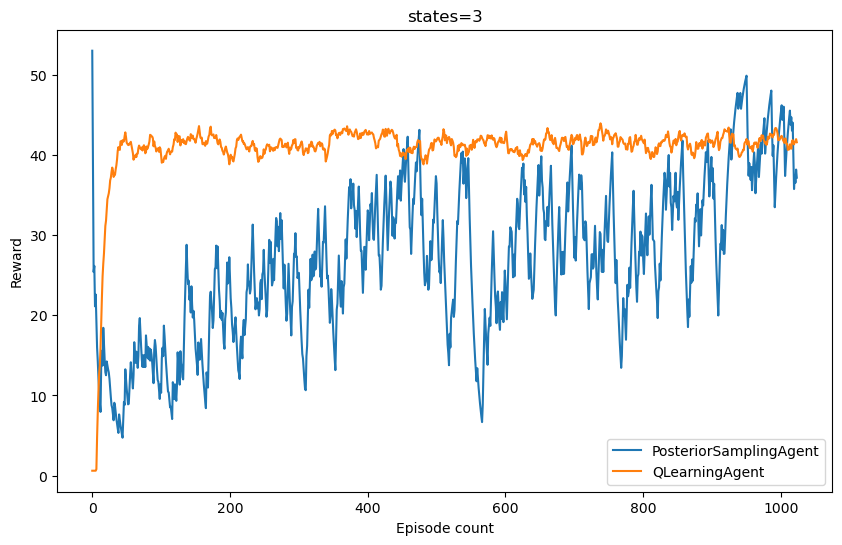

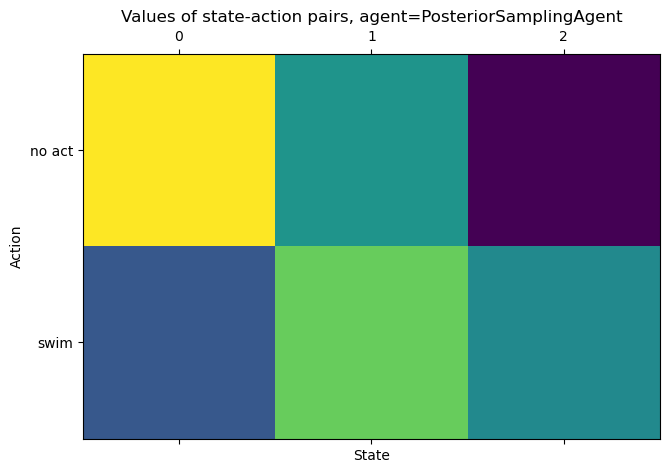

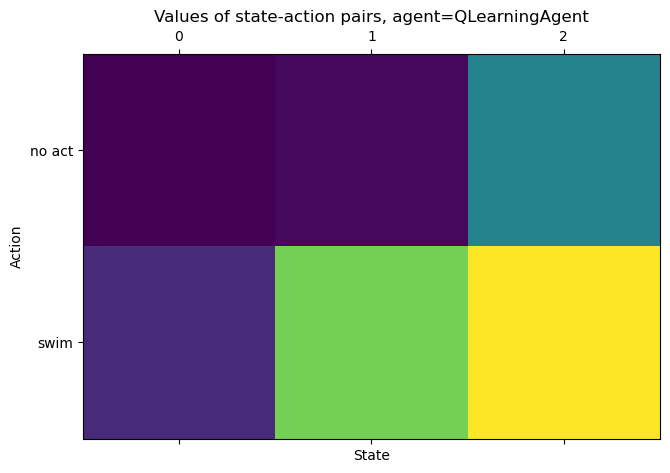

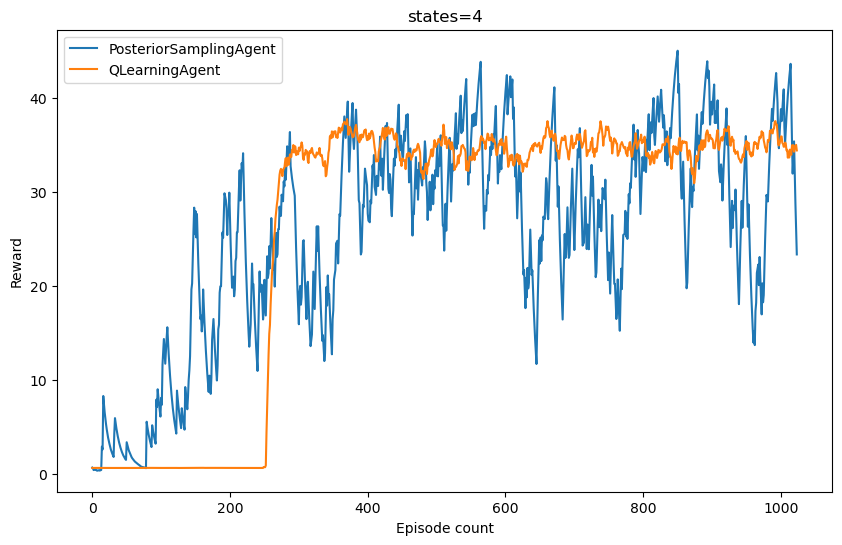

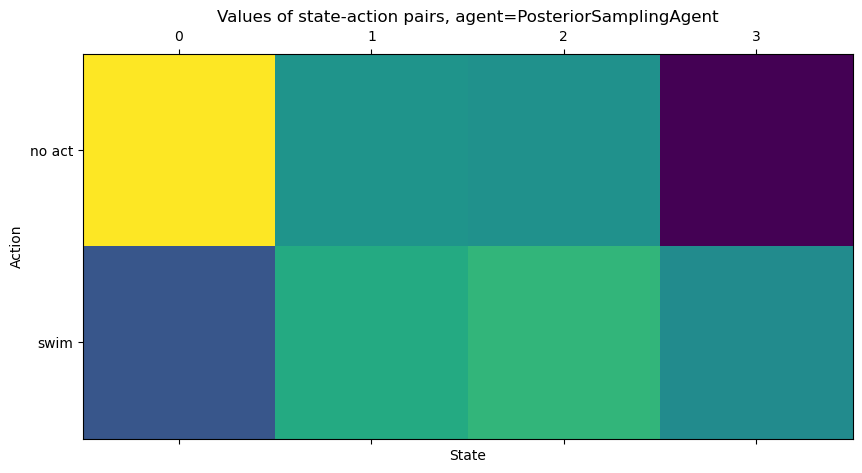

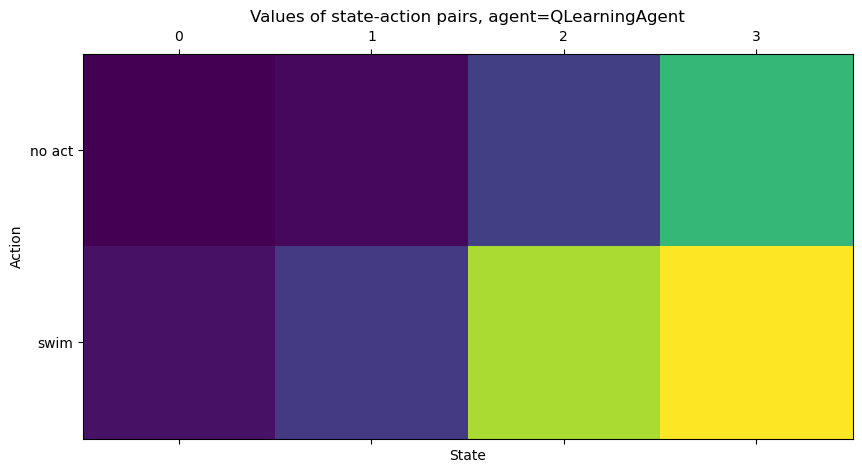

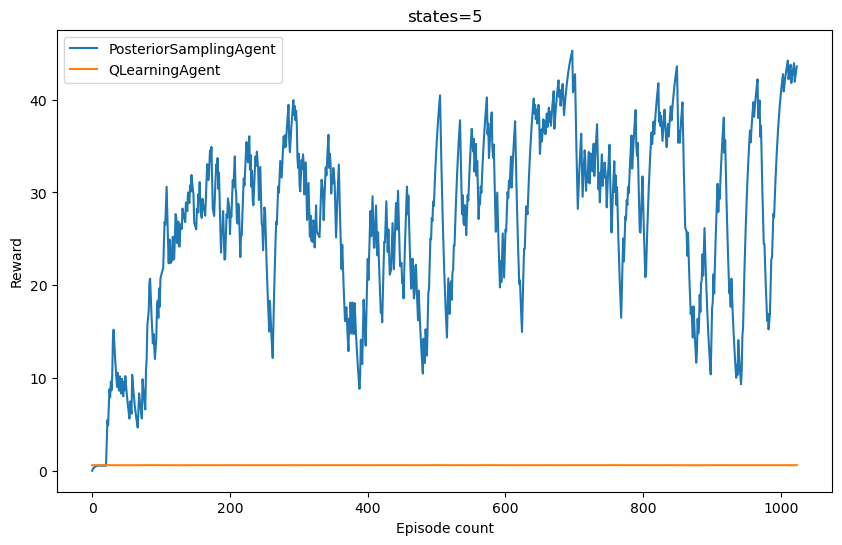

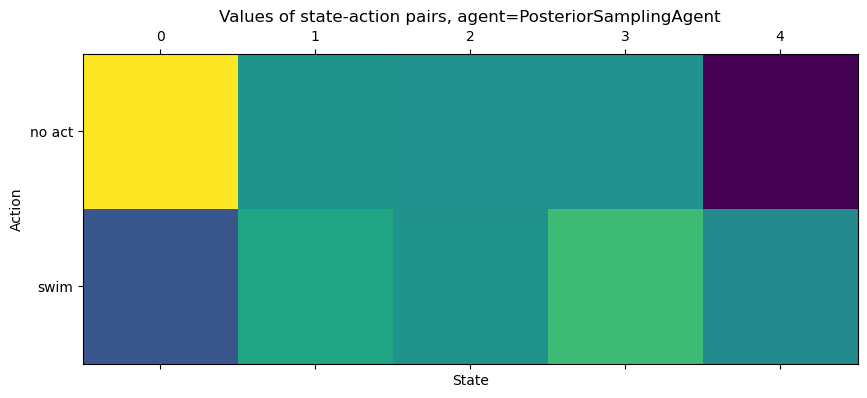

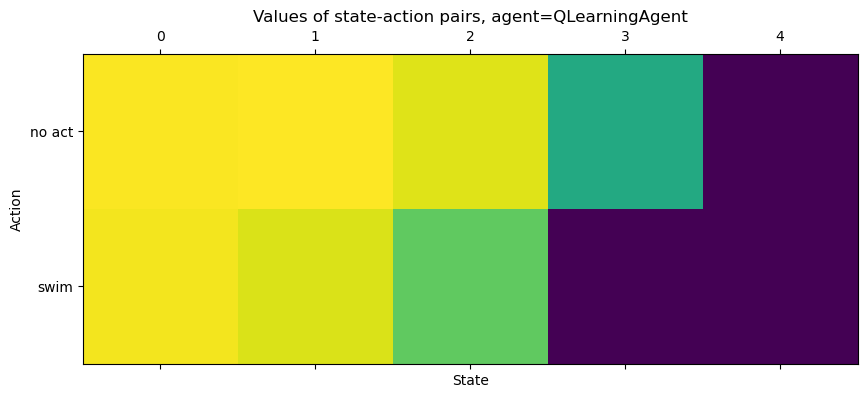

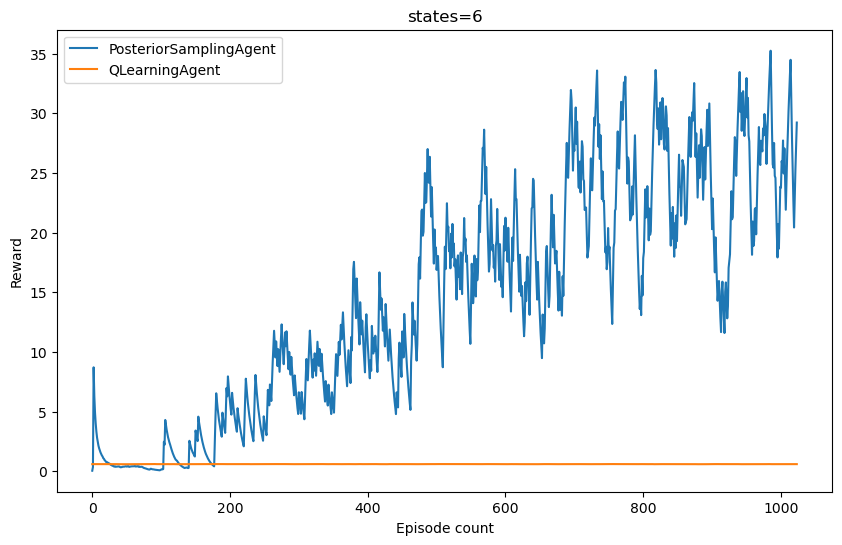

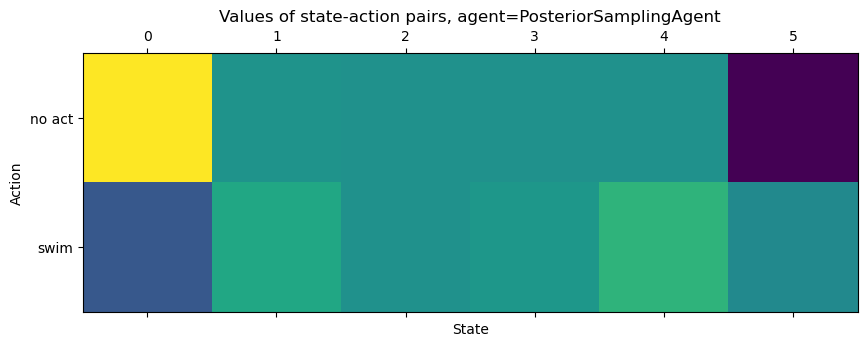

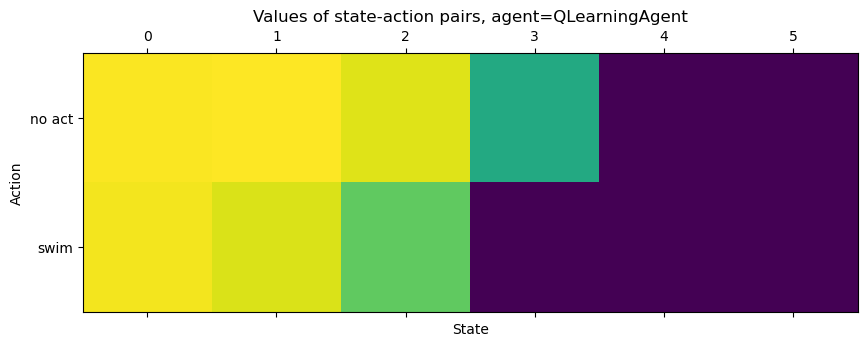

In [170]:
for n in n_states:
    agents = [PosteriorSamplingAgent(2 + n, actions), QLearningAgent(2 + n, actions)]

    rewards = []
    for agent in agents:
        rewards.append(train_river_swim(agent, n, episodes, RiverSwim, ms))

    plt.figure(figsize=(10, 6))

    for i, agent in enumerate(agents):
        plt.plot(pd.DataFrame(np.array(rewards[i])).ewm(alpha=.1).mean(), label=agent.get_name())

    plt.legend()
    plt.title(f"states={n + 2}")
    plt.xlabel("Episode count")
    plt.ylabel("Reward")

    for agent in agents:
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111)
        ax.matshow(agent.get_q_matrix().T)
        ax.set_yticklabels(['', 'no act', 'swim'])

        plt.xlabel("State")
        plt.ylabel("Action")
        plt.title(f"Values of state-action pairs, agent={agent.get_name()}")

plt.show()

### Conslusions (выводы):
  * Как можно видеть из графиков, благодаря рассмотрению апостериорных вероятностей возникла возможность добплыть до конца реки при большом количестве уровней (т.к. после того, как агент получил награду с правого конца реки, он будет пытаться доплыить туда снова).
  * Exploration фаза в случае Posterior Sampling агента качественнее исследует среду, в то же время Q-learning агент быстро привыкает оставаться на берегу (exploitation получается приоритетнее exploration даже при увеличии вероятности $\varepsilon$ — вероятность принятия случайного действия).